# SARIMA Model for Flight Delay Prediction

This notebook implements a Seasonal AutoRegressive Integrated Moving Average (SARIMA) model for predicting flight delays. We'll use the preprocessed time series data from the `04_ts_preprocessing.ipynb` notebook.

## Overview

SARIMA is a powerful time series forecasting method that is well-suited for data with both trend and seasonality, such as flight delay patterns. In this notebook, we will:

1. Load the preprocessed data
2. Explore the time series characteristics
3. Identify optimal SARIMA parameters 
4. Train the SARIMA model
5. Make forecasts and evaluate performance
6. Visualize the results

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle

# Statistical and Time Series libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Progress bar
from tqdm.notebook import tqdm

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Check if directories exist
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Time Series processed data path: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/data/processed/ts_ready_flights
Time Series model path: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/ts
Libraries and paths configured.


In [2]:
# Load the preprocessed time series data
ts_data_path = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.pkl')

# Check if the pickle file exists, otherwise try CSV
if os.path.exists(ts_data_path):
    print(f"Loading preprocessed data from {ts_data_path}")
    df = pd.read_pickle(ts_data_path)
else:
    # Try loading CSV if pickle not found
    csv_path = os.path.join(TS_PROCESSED_PATH, 'complete_ts_preprocessed_flights.csv')
    if os.path.exists(csv_path):
        print(f"Pickle file not found. Loading from CSV: {csv_path}")
        df = pd.read_csv(csv_path)
        # Convert date columns to datetime
        date_columns = [col for col in df.columns if 'DATE' in col.upper()]
        for col in date_columns:
            df[col] = pd.to_datetime(df[col])
    else:
        raise FileNotFoundError(f"Preprocessed data files not found in {TS_PROCESSED_PATH}")

# Display basic information about the loaded data
print("\nDataset information:")
print(f"Shape: {df.shape}")
print(f"Date range: {df['FL_DATE'].min()} to {df['FL_DATE'].max()}")
print(f"Number of time points: {df['FL_DATE'].nunique()}")

# Display first few rows
print("\nFirst few rows of the data:")
display(df.head())

Loading preprocessed data from /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/data/processed/ts_ready_flights/complete_ts_preprocessed_flights.pkl

Dataset information:
Shape: (500000, 90)
Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00
Number of time points: 1338

First few rows of the data:


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY,DATETIME,DEP_DELAY_lag1,DEP_DELAY_lag2,DEP_DELAY_lag3,DEP_DELAY_lag7,DEP_DELAY_lag14,DEP_DELAY_lag21,DEP_DELAY_lag28,DEP_DELAY_roll_mean3,DEP_DELAY_roll_std3,DEP_DELAY_roll_min3,DEP_DELAY_roll_max3,DEP_DELAY_roll_median3,DEP_DELAY_roll_mean7,DEP_DELAY_roll_std7,DEP_DELAY_roll_min7,DEP_DELAY_roll_max7,DEP_DELAY_roll_median7,DEP_DELAY_roll_mean14,DEP_DELAY_roll_std14,DEP_DELAY_roll_min14,DEP_DELAY_roll_max14,DEP_DELAY_roll_median14,DEP_DELAY_roll_mean28,DEP_DELAY_roll_std28,DEP_DELAY_roll_min28,DEP_DELAY_roll_max28,DEP_DELAY_roll_median28,ARR_DELAY_lag1,ARR_DELAY_lag2,ARR_DELAY_lag3,ARR_DELAY_lag7,ARR_DELAY_lag14,ARR_DELAY_lag21,ARR_DELAY_lag28,ARR_DELAY_roll_mean3,ARR_DELAY_roll_std3,ARR_DELAY_roll_min3,ARR_DELAY_roll_max3,ARR_DELAY_roll_median3,ARR_DELAY_roll_mean7,ARR_DELAY_roll_std7,ARR_DELAY_roll_min7,ARR_DELAY_roll_max7,ARR_DELAY_roll_median7,ARR_DELAY_roll_mean14,ARR_DELAY_roll_std14,ARR_DELAY_roll_min14,ARR_DELAY_roll_max14,ARR_DELAY_roll_median14,ARR_DELAY_roll_mean28,ARR_DELAY_roll_std28,ARR_DELAY_roll_min28,ARR_DELAY_roll_max28,ARR_DELAY_roll_median28
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,0.081315,-0.218902,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",-0.168986,-0.184314,0.000,0.500,-0.154589,-0.066975,-0.400000,-0.028226,-0.065668,0.000,0,0,0.714286,0.662651,0.7125,0.603916,-0.666667,-1,-1.0,-0.466667,-0.25,-2,0,-0.250,Morning,2019-01-09 11:00:00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,-0.242215,-0.373179,MSP,"Minneapolis, MN",SEA,"Seattle, WA",0.954274,0.919608,0.000,-0.750,0.948068,0.844111,4.240919,0.967742,0.928571,0.000,0,0,1.297619,1.385542,1.1625,1.106928,0.333333,2,1.0,0.200000,0.50,1,1,1.000,Evening,2022-11-19 21:00:00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,0.081315,-0.630930,DEN,"Denver, CO",MSP,"Minneapolis, MN",-0.409543,-0.401961,0.750,0.625,-0.384058,-0.293303,-0.200000,-0.288306,-0.290323,0.000,0,0,-0.095238,-0.108434,-0.1125,0.024096,0.333333,1,0.2,0.400000,0.25,0,0,-0.500,Morning,2022-07-22 09:00:00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.250,0.433013,0.0,0.750,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,-0.242215,0.054912,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",0.335984,0.319608,0.000,1.500,0.358696,0.396074,0.600000,0.391129,0.402074,3.000,0,0,1.595238,1.975904,1.9125,1.393072,0.666667,-1,-0.6,-0.666667,-0.75,-1,0,0.375,Afternoon,2023-03-06 16:00:00,0.75,0.00,0.0,0.0,0.0,0.0,0.0,0.250,0.433013,0.0,0.750,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,1.732051,0.0,3.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,-0.929066,-0.553978,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",-0.377734,-0.094118,18.375,0.000,-0.103865,-0.199769,-0.600000,-0.493952,-0.199309,17.625,0,0,-0.785714,-0.807229,-0.7500,-0.727410,-0.666667,1,0.2,1.000000,-0.25,0,0,-0.375,Morning,2019-07-31 10:00:00,0.00,0.75,0.0,0.0,

## Data Preparation for SARIMA

SARIMA models require single time series data with a regular time interval. We'll prepare the data by:

1. Aggregating to daily averages if not already done
2. Setting up the time series with proper datetime index
3. Checking for and handling any remaining missing values
4. Examining the stationarity and seasonality of the target time series

Data contains multiple entries per day. Aggregating to daily level...
Filling 366 missing values in the time series...


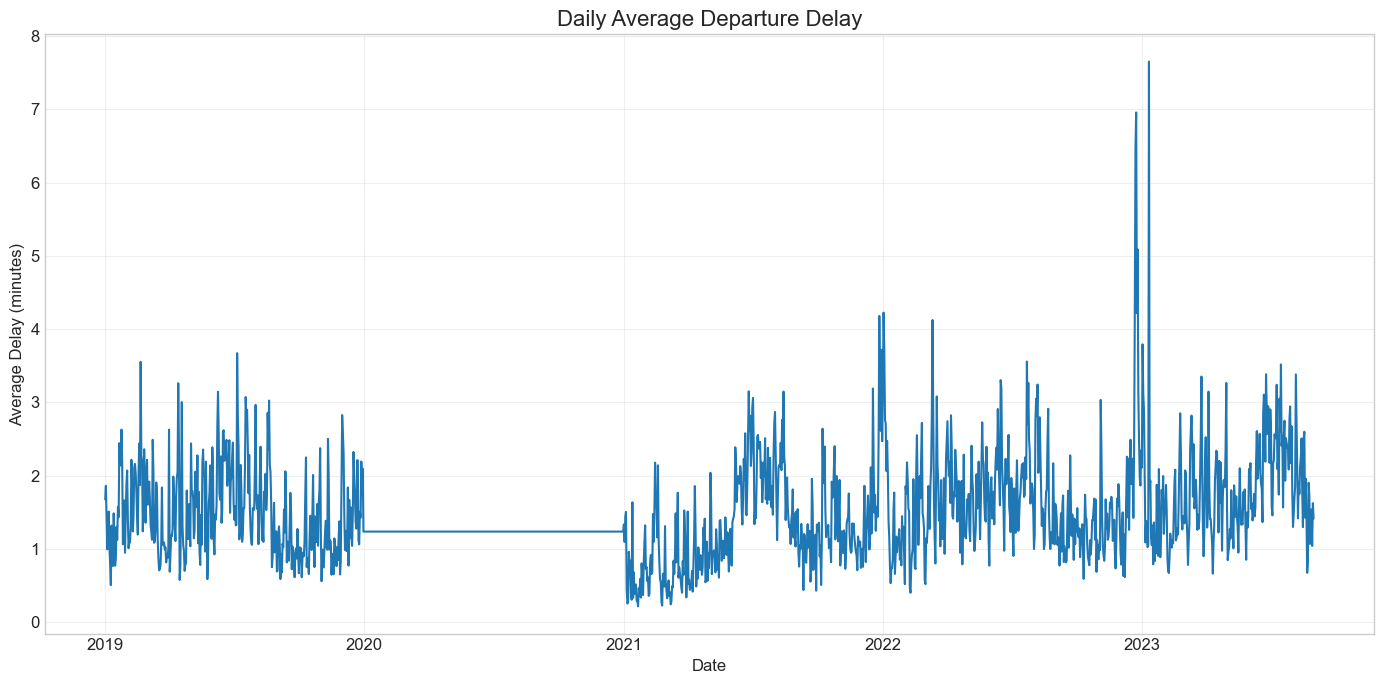


Time Series Summary Statistics:
count    1704.000000
mean        1.479603
std         0.654946
min         0.215038
25%         1.136184
50%         1.235770
75%         1.788063
max         7.652623
Name: DEP_DELAY, dtype: float64


In [3]:
# Aggregate data to daily level if needed
def prepare_daily_time_series(df, target_col='DEP_DELAY'):
    """
    Prepare a daily time series from the dataframe for SARIMA modeling
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target_col : str
        The target column to use for time series modeling
    
    Returns:
    --------
    pd.Series
        Daily time series with datetime index
    """
    # Check if data is already aggregated or needs aggregation
    if df['FL_DATE'].nunique() < len(df):
        print("Data contains multiple entries per day. Aggregating to daily level...")
        
        # Group by date and calculate mean of the target column
        daily_ts = df.groupby('FL_DATE')[target_col].mean()
    else:
        print("Data is already at daily level. Creating time series...")
        # Create a time series from the target column with FL_DATE as index
        df_copy = df.copy()
        df_copy.set_index('FL_DATE', inplace=True)
        daily_ts = df_copy[target_col]
    
    # Sort the index to ensure chronological order
    daily_ts = daily_ts.sort_index()
    
    # Ensure there are no missing dates in the time series
    date_range = pd.date_range(start=daily_ts.index.min(), end=daily_ts.index.max(), freq='D')
    daily_ts = daily_ts.reindex(date_range)
    
    # Fill missing values if any
    if daily_ts.isna().any():
        print(f"Filling {daily_ts.isna().sum()} missing values in the time series...")
        # Forward fill, then backward fill for any remaining NAs
        daily_ts = daily_ts.fillna(method='ffill').fillna(method='bfill')
    
    return daily_ts

# Create a daily time series for the target variable (departure delay)
ts_daily = prepare_daily_time_series(df, target_col='DEP_DELAY')

# Plot the daily time series
plt.figure(figsize=(14, 7))
plt.plot(ts_daily.index, ts_daily.values, linewidth=1.5)
plt.title('Daily Average Departure Delay', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary statistics
print("\nTime Series Summary Statistics:")
print(ts_daily.describe())

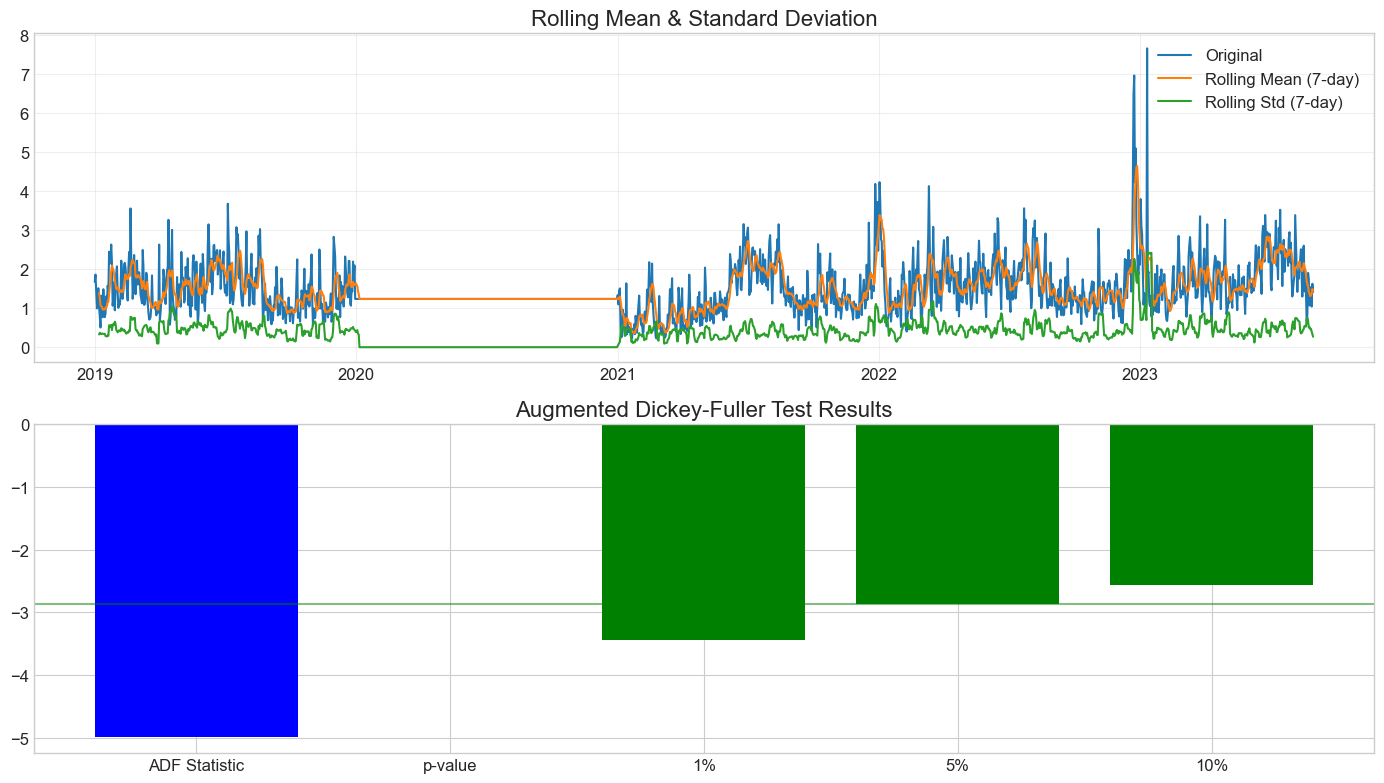

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.9958
p-value: 0.0000
Critical Values:
   1%: -3.4342
   5%: -2.8633
   10%: -2.5677

Conclusion: Time series is stationary (reject null hypothesis)


In [4]:
# Check stationarity of the time series using the Augmented Dickey-Fuller test
def check_stationarity(ts, window=7):
    """
    Check if a time series is stationary using Augmented Dickey-Fuller test
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to check
    window : int
        Window size for rolling statistics
    
    Returns:
    --------
    bool
        True if the series is stationary, False otherwise
    """
    # Calculate rolling statistics
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(14, 8))
    plt.subplot(211)
    plt.plot(ts.index, ts, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({window}-day)')
    plt.plot(rolling_std.index, rolling_std, label=f'Rolling Std ({window}-day)')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(ts.dropna())
    
    plt.subplot(212)
    plt.bar(['ADF Statistic', 'p-value', '1%', '5%', '10%'], 
            [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']], 
            color=['blue', 'red', 'green', 'green', 'green'])
    plt.axhline(y=result[4]['5%'], color='green', linestyle='-', alpha=0.5)
    plt.title('Augmented Dickey-Fuller Test Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print test results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("\nConclusion: Time series is stationary (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Time series is non-stationary (fail to reject null hypothesis)")
        return False

# Check stationarity of the daily time series
is_stationary = check_stationarity(ts_daily)

In [5]:
# If time series is not stationary, apply differencing
def apply_differencing(ts, d=1, D=0, seasonal_periods=7):
    """
    Apply differencing to make time series stationary
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to difference
    d : int
        Order of regular differencing
    D : int
        Order of seasonal differencing
    seasonal_periods : int
        Number of periods in each season
    
    Returns:
    --------
    pd.Series
        Differenced time series
    """
    # Create a copy of the time series
    ts_diff = ts.copy()
    
    # Apply regular differencing
    if d > 0:
        for i in range(d):
            ts_diff = ts_diff.diff().dropna()
            print(f"Applied order {i+1} differencing")
    
    # Apply seasonal differencing
    if D > 0:
        for i in range(D):
            ts_diff = ts_diff.diff(seasonal_periods).dropna()
            print(f"Applied order {i+1} seasonal differencing with period {seasonal_periods}")
    
    return ts_diff

# Apply differencing if the time series is not stationary
if not is_stationary:
    # First try regular differencing (d=1)
    ts_diff = apply_differencing(ts_daily, d=1)
    
    # Check if differenced series is stationary
    print("\nChecking stationarity after differencing:")
    is_stationary_diff = check_stationarity(ts_diff)
    
    # If still not stationary, try seasonal differencing
    if not is_stationary_diff:
        print("\nApplying seasonal differencing:")
        ts_diff = apply_differencing(ts_daily, d=1, D=1, seasonal_periods=7)
        
        # Check stationarity again
        print("\nChecking stationarity after seasonal differencing:")
        is_stationary_diff = check_stationarity(ts_diff)
else:
    ts_diff = ts_daily

Time series decomposition with weekly seasonality (period=7):


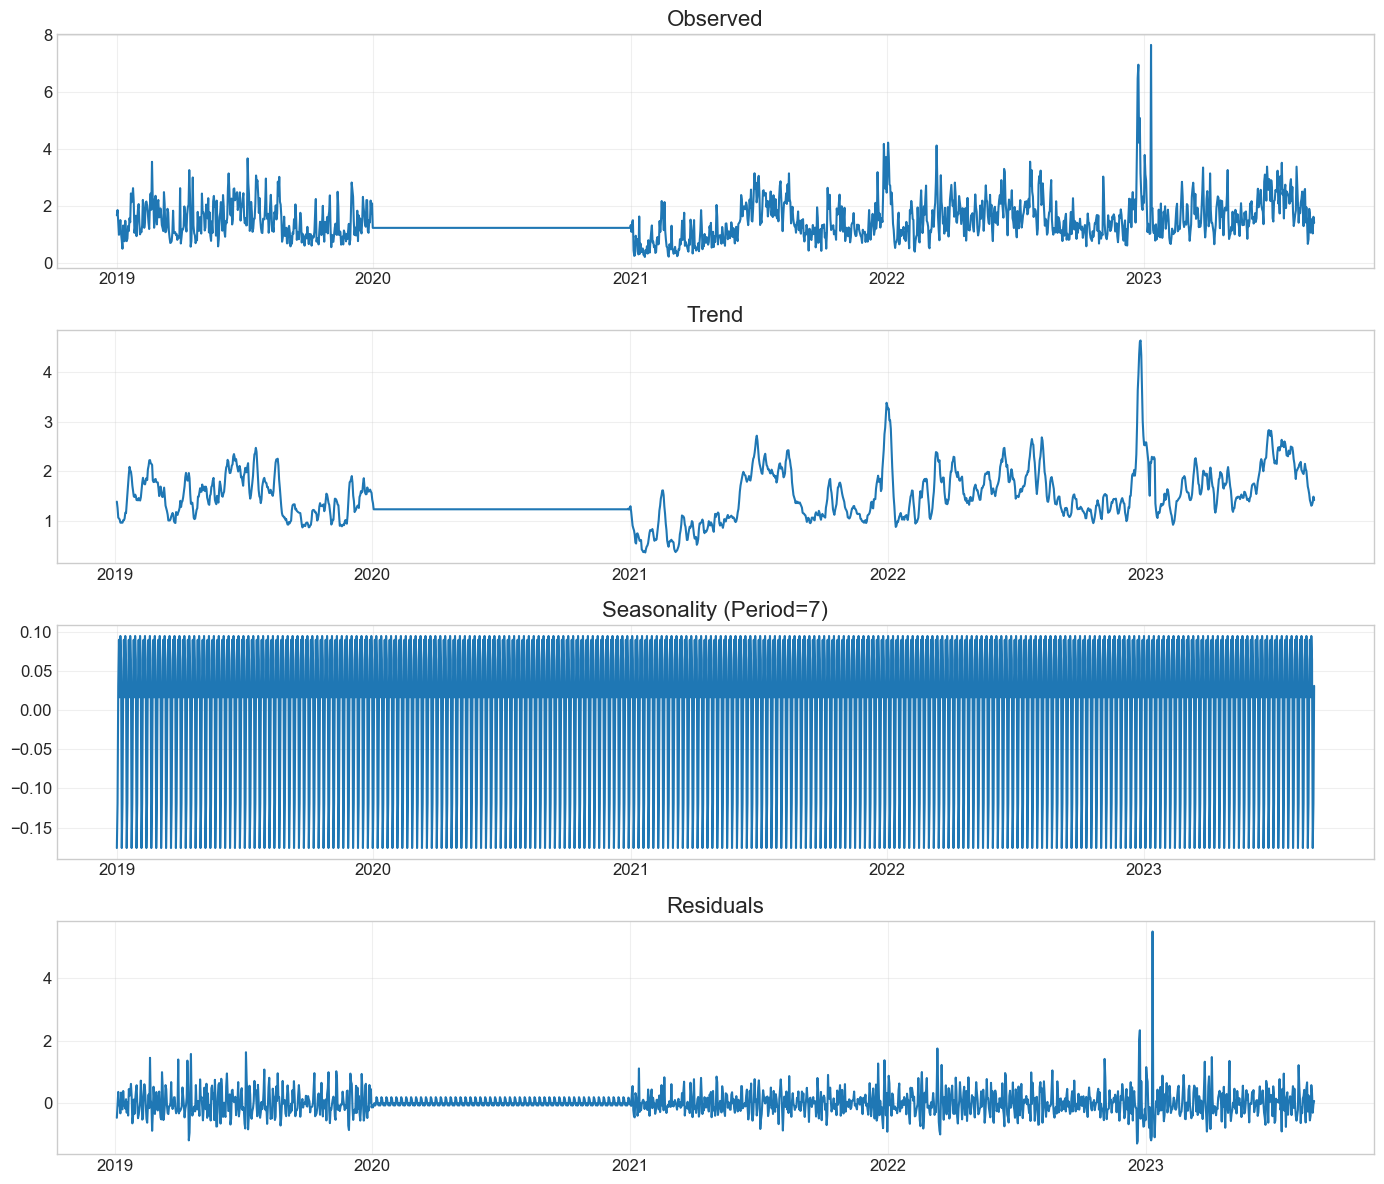

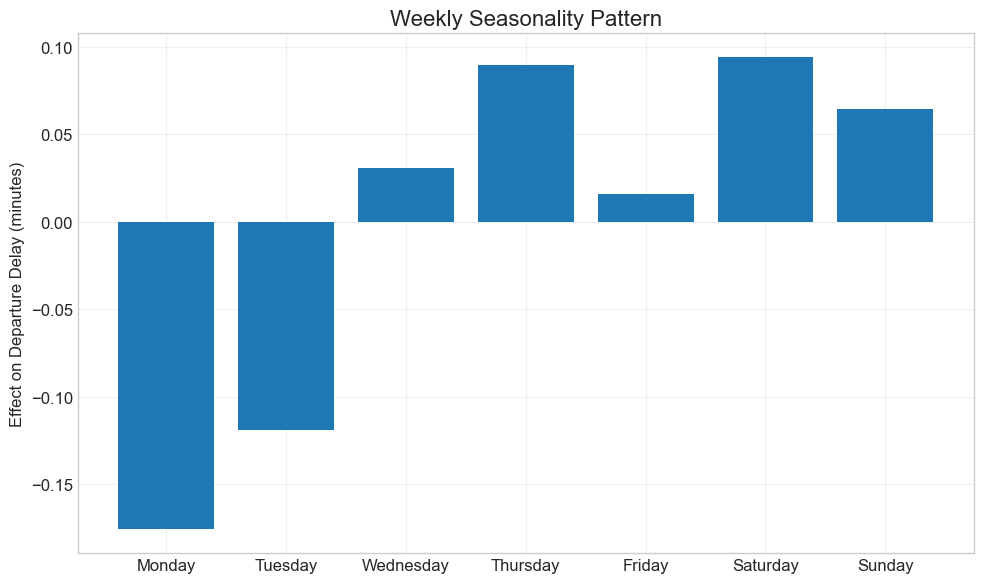


Time series decomposition with monthly seasonality (period=30):


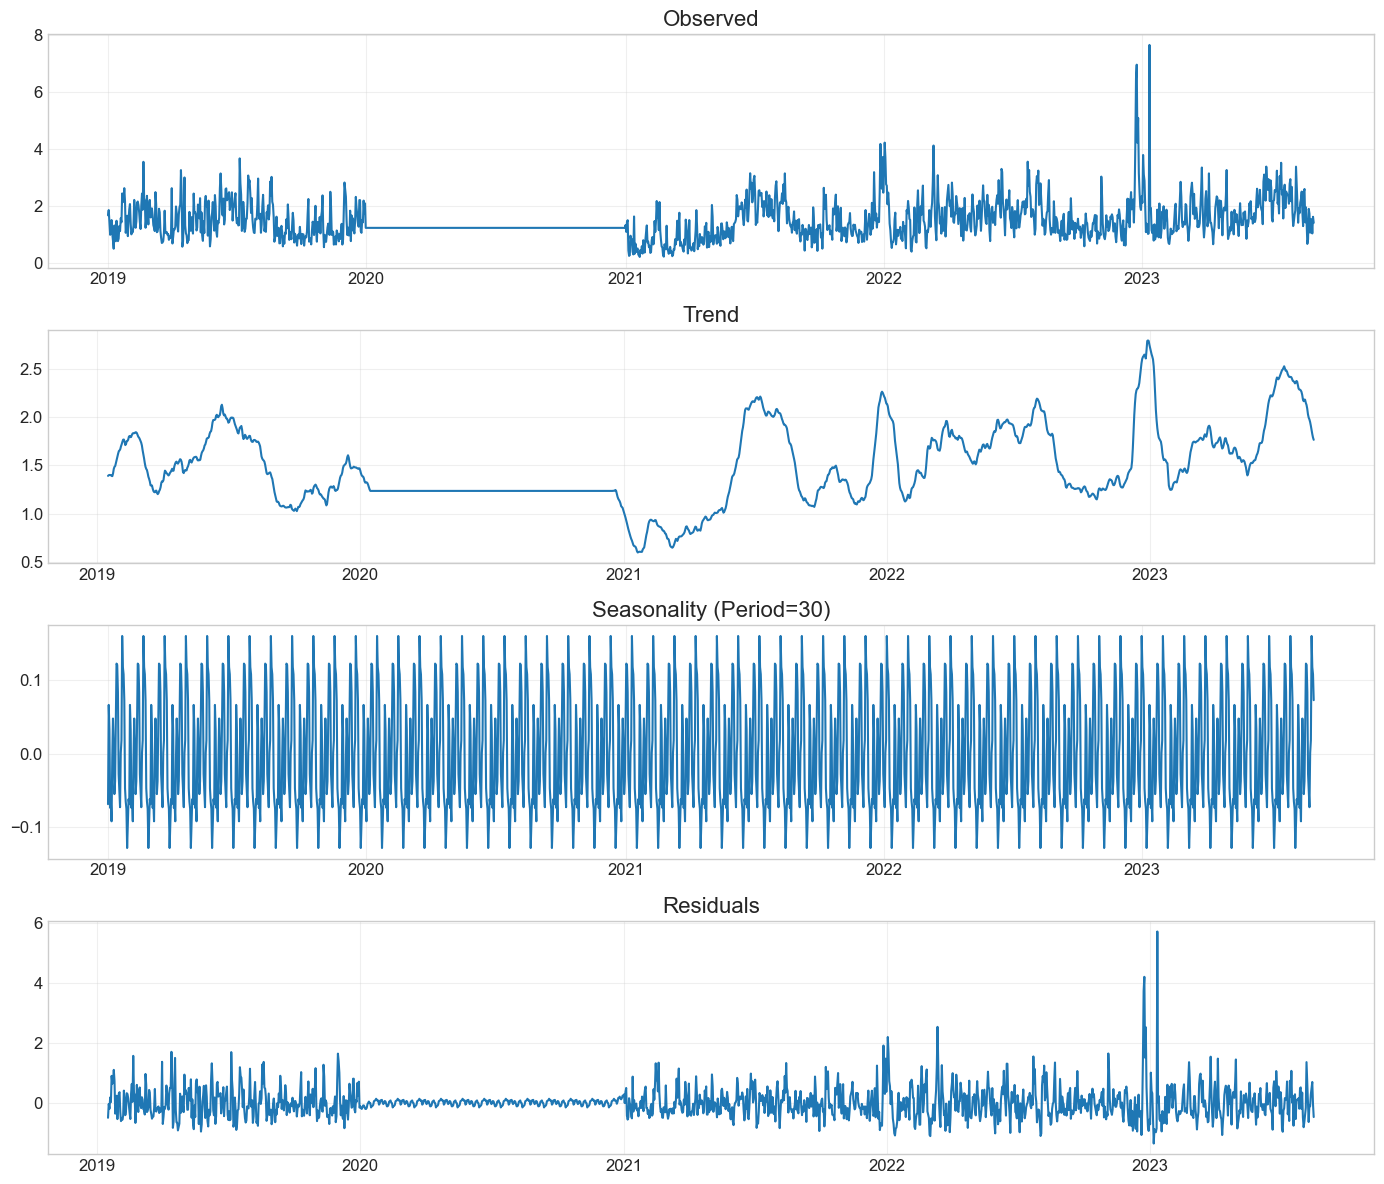

In [6]:
# Identify seasonal patterns and decompose the time series
def decompose_time_series(ts, period=7):
    """
    Decompose time series into trend, seasonal, and residual components
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to decompose
    period : int
        The seasonal period (7 for weekly, 30 for monthly, 365 for yearly)
    
    Returns:
    --------
    statsmodels.tsa.seasonal.DecomposeResult
        Decomposition result object
    """
    # Ensure there are no missing values
    ts_filled = ts.fillna(method='ffill').fillna(method='bfill')
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts_filled, model='additive', period=period)
    
    # Plot decomposition
    plt.figure(figsize=(14, 12))
    
    plt.subplot(411)
    plt.plot(decomposition.observed)
    plt.title('Observed', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(412)
    plt.plot(decomposition.trend)
    plt.title('Trend', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(413)
    plt.plot(decomposition.seasonal)
    plt.title(f'Seasonality (Period={period})', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(414)
    plt.plot(decomposition.resid)
    plt.title('Residuals', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return decomposition

# Decompose with weekly seasonality
print("Time series decomposition with weekly seasonality (period=7):")
decomp_weekly = decompose_time_series(ts_daily, period=7)

# Extract weekly seasonal pattern
weekly_pattern = decomp_weekly.seasonal[:7]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
plt.bar(days, weekly_pattern)
plt.title('Weekly Seasonality Pattern', fontsize=16)
plt.ylabel('Effect on Departure Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Try monthly seasonality if data spans multiple months
if len(ts_daily) >= 60:  # At least 2 months of data
    print("\nTime series decomposition with monthly seasonality (period=30):")
    decomp_monthly = decompose_time_series(ts_daily, period=30)

ACF and PACF analysis of the prepared time series:


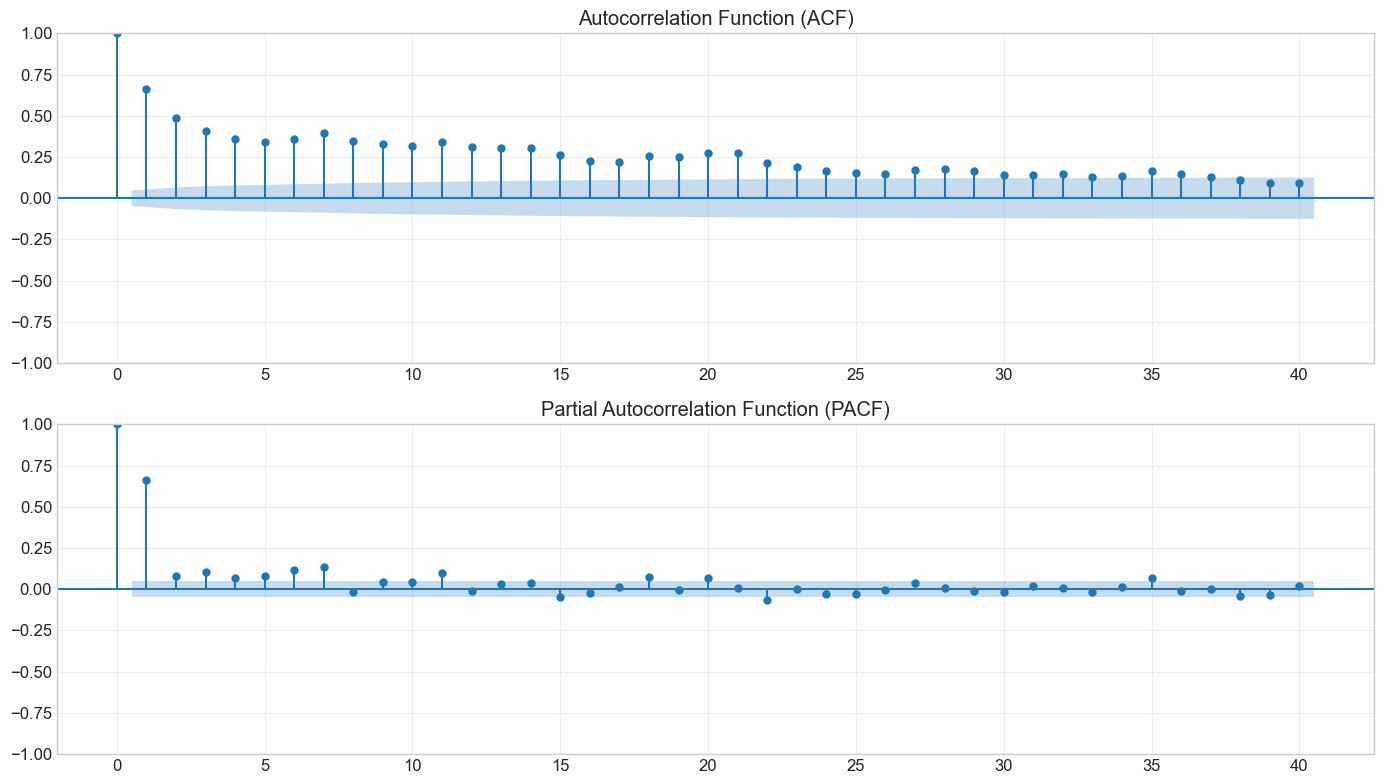

In [7]:
# Analyze ACF and PACF to identify potential SARIMA parameters
def analyze_acf_pacf(ts, lags=40):
    """
    Plot ACF and PACF to help identify AR and MA orders
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to analyze
    lags : int
        Number of lags to include in the plots
    """
    plt.figure(figsize=(14, 8))
    
    plt.subplot(211)
    plot_acf(ts.dropna(), lags=lags, alpha=0.05, title='Autocorrelation Function (ACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts.dropna(), lags=lags, alpha=0.05, method='ols', title='Partial Autocorrelation Function (PACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze ACF and PACF of the differenced series
print("ACF and PACF analysis of the prepared time series:")
analyze_acf_pacf(ts_diff)

## SARIMA Model Parameter Selection

Based on the ACF and PACF plots, we can identify potential SARIMA parameters. The SARIMA model is described as SARIMA(p,d,q)(P,D,Q)s where:

- p: Order of the AR term (regular)
- d: Order of differencing (regular)
- q: Order of the MA term (regular)
- P: Order of the AR term (seasonal)
- D: Order of differencing (seasonal)
- Q: Order of the MA term (seasonal)
- s: Seasonal period

Let's try a few parameter combinations and select the best model based on AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion).

In [8]:
# Grid search for optimal SARIMA parameters
def sarima_grid_search(ts, p_range, d_range, q_range, P_range, D_range, Q_range, s=7):
    """
    Perform grid search to find optimal SARIMA parameters
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to model
    p_range, d_range, q_range : list
        Ranges of values for p, d, q parameters (regular components)
    P_range, D_range, Q_range : list
        Ranges of values for P, D, Q parameters (seasonal components)
    s : int
        Seasonal period
    
    Returns:
    --------
    dict
        Best parameters and their AIC value
    """
    best_aic = float('inf')
    best_params = None
    
    # Create a list to store results
    results = []
    
    # Calculate total number of combinations
    total_combinations = (len(p_range) * len(d_range) * len(q_range) * 
                         len(P_range) * len(D_range) * len(Q_range))
    
    print(f"Testing {total_combinations} SARIMA model configurations...")
    
    # Grid search with progress bar
    with tqdm(total=total_combinations) as pbar:
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                # Create and fit the model
                                try:
                                    model = SARIMAX(ts, 
                                                   order=(p, d, q), 
                                                   seasonal_order=(P, D, Q, s),
                                                   enforce_stationarity=False,
                                                   enforce_invertibility=False)
                                    model_fit = model.fit(disp=False)
                                    
                                    # Get AIC
                                    aic = model_fit.aic
                                    
                                    # Store results
                                    params = (p, d, q, P, D, Q, s)
                                    results.append({
                                        'params': params,
                                        'aic': aic,
                                        'bic': model_fit.bic
                                    })
                                    
                                    # Update best parameters if AIC is lower
                                    if aic < best_aic:
                                        best_aic = aic
                                        best_params = params
                                        
                                except Exception as e:
                                    # Skip this combination if model doesn't converge
                                    pass
                                
                                # Update progress bar
                                pbar.update(1)
    
    # Sort results by AIC
    results = sorted(results, key=lambda x: x['aic'])
    
    # Display top 5 models
    print("\nTop 5 SARIMA Models by AIC:")
    for i, result in enumerate(results[:5]):
        params = result['params']
        print(f"Rank {i+1}: SARIMA{params[:-1]}x{params[-1]} - AIC: {result['aic']:.2f}, BIC: {result['bic']:.2f}")
    
    return best_params, results

# Define parameter ranges
# Keep ranges small for demonstration; expand for better results
p_range = range(0, 3)   # AR order
d_range = range(0, 2)   # Differencing order
q_range = range(0, 3)   # MA order
P_range = range(0, 2)   # Seasonal AR order
D_range = range(0, 2)   # Seasonal differencing order
Q_range = range(0, 2)   # Seasonal MA order
s = 7                   # Seasonal period (weekly)

# Run the grid search
best_params, all_results = sarima_grid_search(
    ts_daily,  # Use original series, let SARIMA handle differencing
    p_range, d_range, q_range, 
    P_range, D_range, Q_range, 
    s
)

Testing 144 SARIMA model configurations...


  0%|          | 0/144 [00:00<?, ?it/s]


Top 5 SARIMA Models by AIC:
Rank 1: SARIMA(2, 0, 1, 0, 1, 1)x7 - AIC: 2250.07, BIC: 2277.22
Rank 2: SARIMA(2, 0, 2, 0, 1, 1)x7 - AIC: 2251.46, BIC: 2284.04
Rank 3: SARIMA(2, 0, 1, 1, 1, 1)x7 - AIC: 2252.47, BIC: 2285.06
Rank 4: SARIMA(2, 0, 2, 1, 1, 1)x7 - AIC: 2252.96, BIC: 2290.98
Rank 5: SARIMA(2, 0, 2, 1, 0, 1)x7 - AIC: 2262.49, BIC: 2300.53


Fitting SARIMA(2, 0, 1)x(0, 1, 1, 7) model...

Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                         DEP_DELAY   No. Observations:                 1704
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1120.033
Date:                           Thu, 22 May 2025   AIC                           2250.065
Time:                                   12:57:24   BIC                           2277.222
Sample:                               01-01-2019   HQIC                          2260.122
                                    - 08-31-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4119      0.019     74.857      0.000      

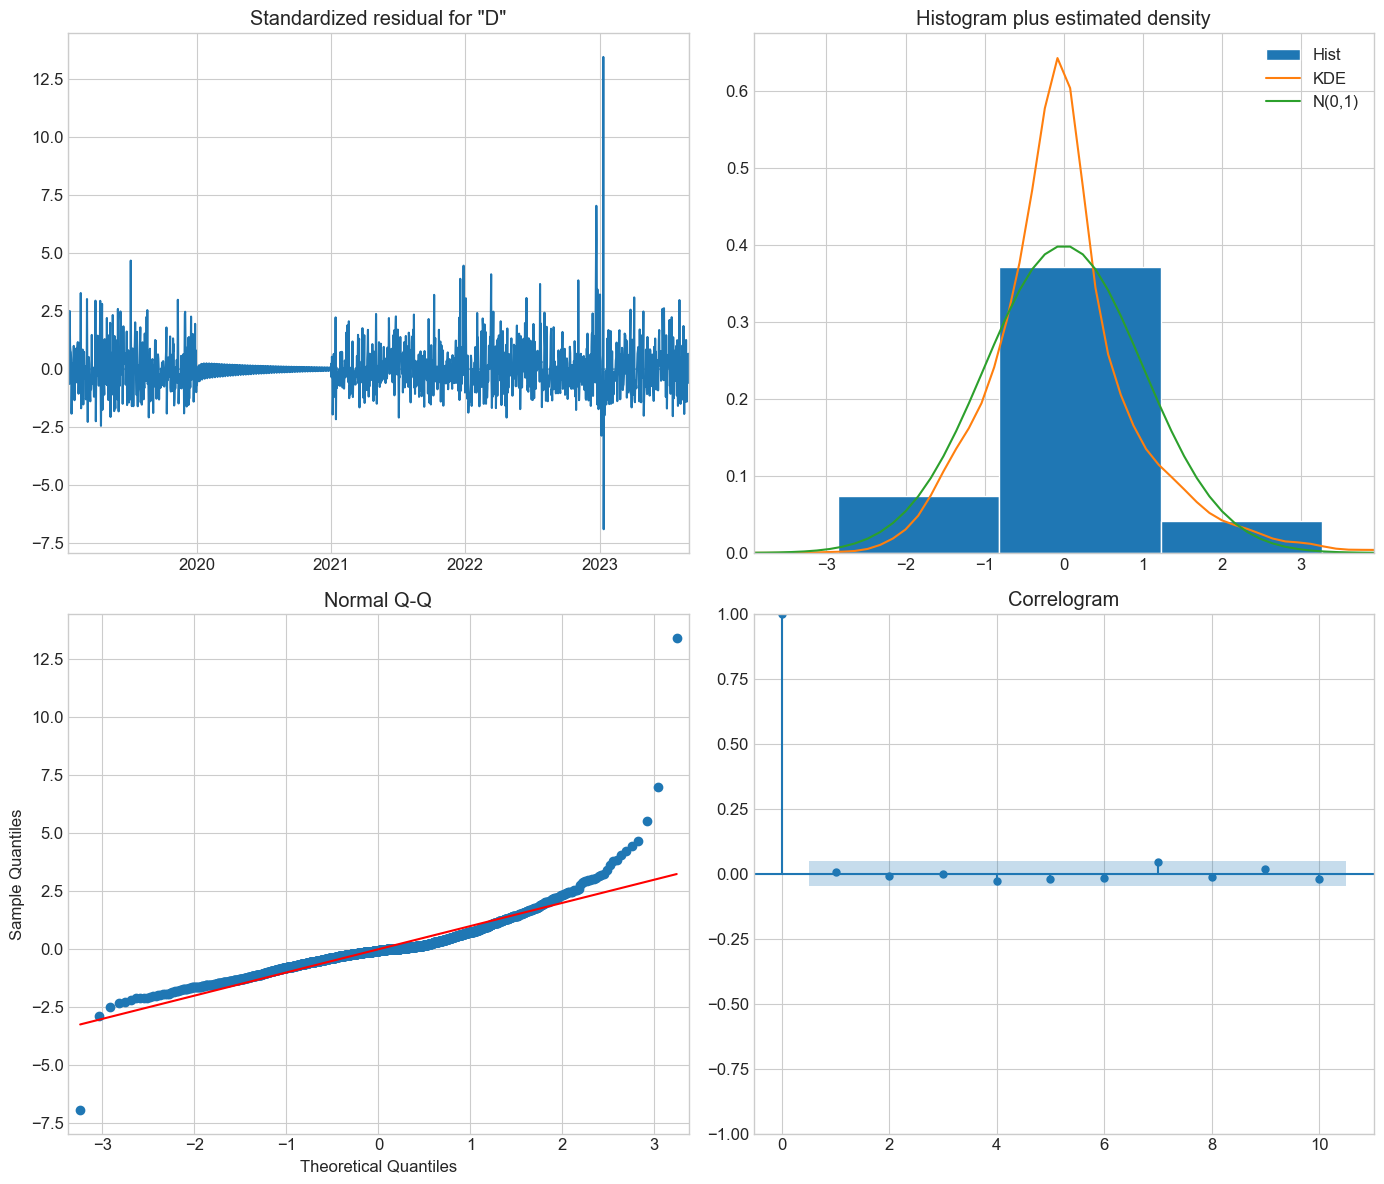

In [9]:
# Fit the best SARIMA model
def fit_sarima_model(ts, order, seasonal_order):
    """
    Fit a SARIMA model with the specified parameters
    
    Parameters:
    -----------
    ts : pd.Series
        The time series to model
    order : tuple
        (p, d, q) order of the regular components
    seasonal_order : tuple
        (P, D, Q, s) order of the seasonal components
    
    Returns:
    --------
    statsmodels.tsa.statespace.sarimax.SARIMAXResults
        Fitted SARIMA model
    """
    print(f"Fitting SARIMA{order}x{seasonal_order} model...")
    
    # Create and fit the model
    model = SARIMAX(ts, 
                   order=order, 
                   seasonal_order=seasonal_order,
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    
    # Print model summary
    print("\nModel Summary:")
    print(model_fit.summary())
    
    # Diagnostic plots
    print("\nDiagnostic Plots:")
    model_fit.plot_diagnostics(figsize=(14, 12))
    plt.tight_layout()
    plt.show()
    
    return model_fit

# Use the best parameters from grid search
if best_params:
    p, d, q, P, D, Q, s = best_params
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
else:
    # Use reasonable default parameters if grid search failed
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 7)

# Fit the model
best_model = fit_sarima_model(ts_daily, order, seasonal_order)

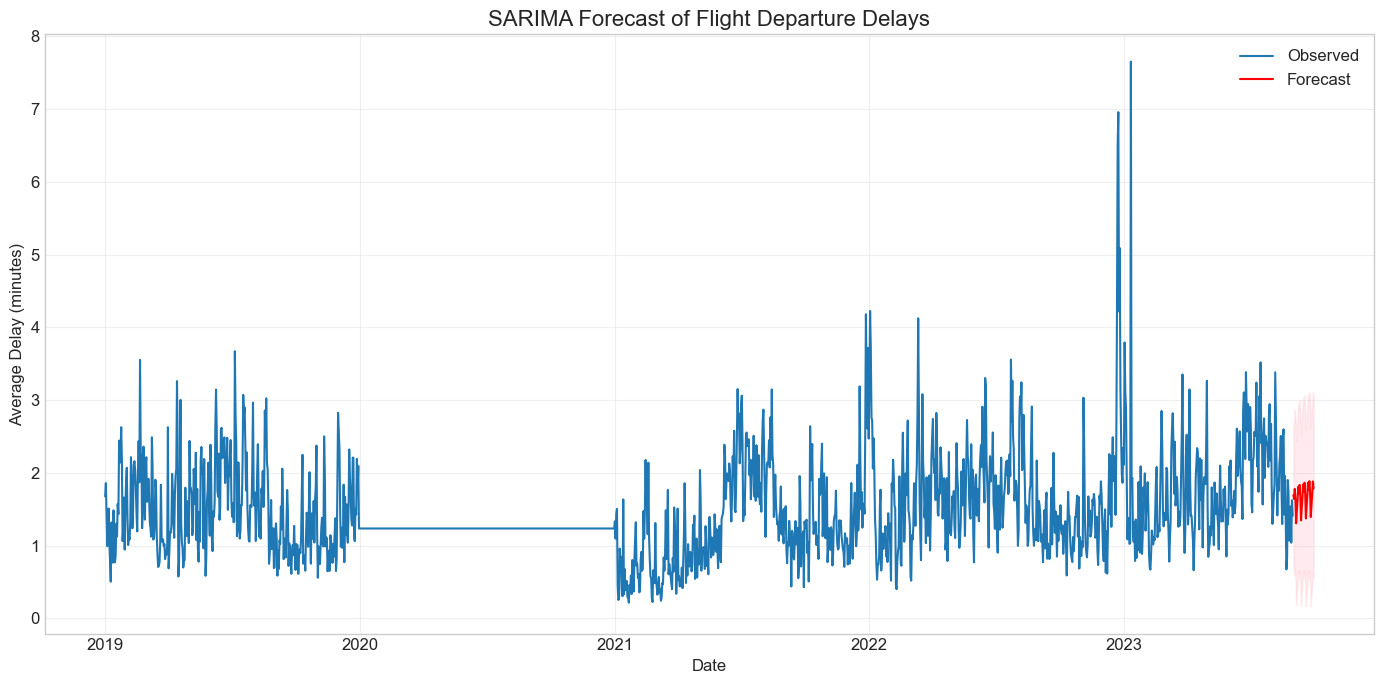


Forecast for the next 30 days:


,Forecast,Lower CI,Upper CI
2023-09-01,1.692270,0.775857,2.608683
2023-09-02,1.641768,0.597762,2.685775
2023-09-03,1.780371,0.691916,2.868827
2023-09-04,1.637169,0.527230,2.747109
2023-09-05,1.307495,0.184147,2.430842
2023-09-06,1.478255,0.344955,2.611555
2023-09-07,1.619962,0.478485,2.761439
2023-09-08,1.808805,0.656876,2.960734
2023-09-09,1.716253,0.556371,2.876134
2023-09-10,1.834890,0.668382,3.001397


In [10]:
# Forecast using the fitted model
def forecast_sarima(model_fit, steps=30, plot=True):
    """
    Generate forecasts from a fitted SARIMA model
    
    Parameters:
    -----------
    model_fit : statsmodels.tsa.statespace.sarimax.SARIMAXResults
        Fitted SARIMA model
    steps : int
        Number of steps to forecast
    plot : bool
        Whether to plot the forecast
    
    Returns:
    --------
    pd.Series
        Forecast values
    pd.DataFrame
        Confidence intervals
    """
    # Generate forecast
    forecast = model_fit.get_forecast(steps=steps)
    
    # Get forecast mean and confidence intervals
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    # Create forecast index
    last_date = model_fit.data.dates[-1]
    forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=steps, freq='D')
    
    # Convert to Series with proper index
    forecast_mean.index = forecast_index
    confidence_intervals.index = forecast_index
    
    if plot:
        # Plot the forecast
        plt.figure(figsize=(14, 7))
        
        # Plot original data
        plt.plot(model_fit.data.dates, model_fit.data.endog, label='Observed')
        
        # Plot forecast
        plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
        
        # Plot confidence intervals
        plt.fill_between(forecast_mean.index, 
                        confidence_intervals.iloc[:, 0], 
                        confidence_intervals.iloc[:, 1], 
                        color='pink', alpha=0.3)
        
        plt.title('SARIMA Forecast of Flight Departure Delays', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Average Delay (minutes)', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return forecast_mean, confidence_intervals

# Generate forecast for the next 30 days
forecast_mean, confidence_intervals = forecast_sarima(best_model, steps=30)

# Display forecast values
print("\nForecast for the next 30 days:")
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
})
display(forecast_df)

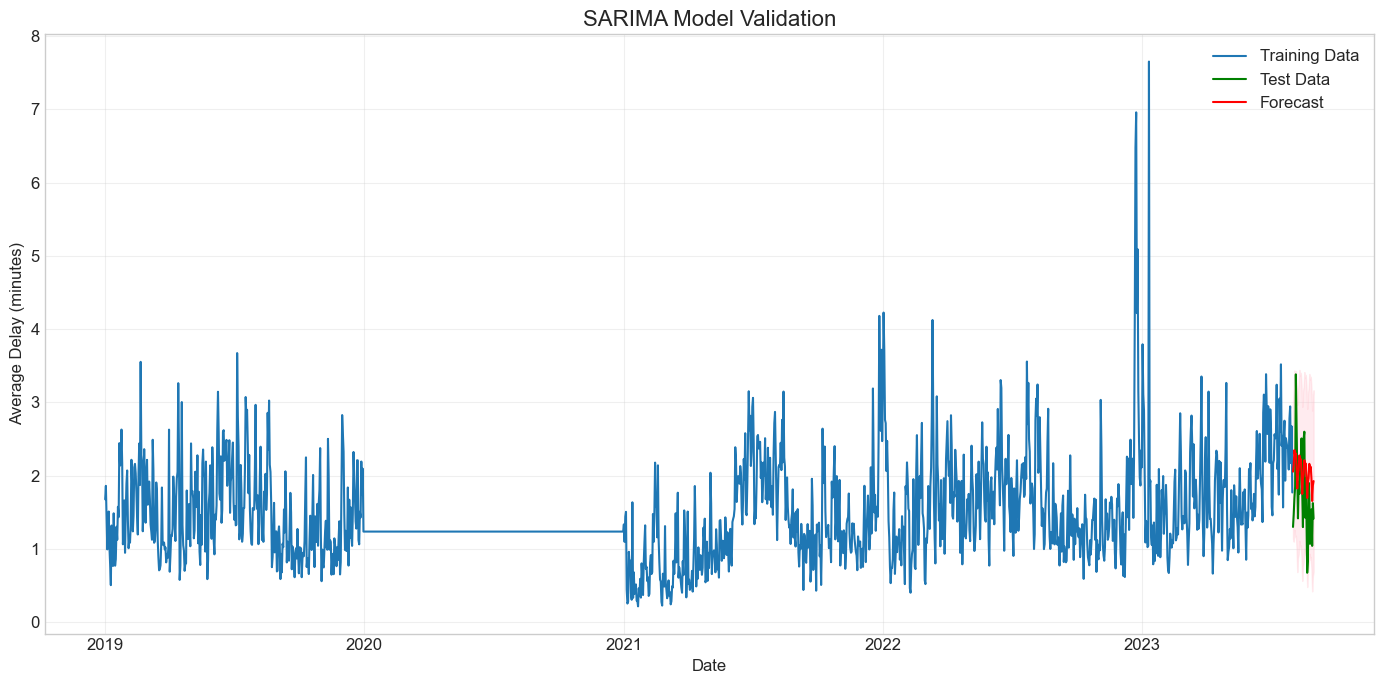


Model Validation Metrics:
Root Mean Squared Error (RMSE): 0.59
Mean Absolute Error (MAE): 0.51
Mean Absolute Percentage Error (MAPE): 36.73%


In [11]:
# Validate the model on a held-out test set
def validate_model(ts, model_fit, test_size=30):
    """
    Validate the model on a held-out test set
    
    Parameters:
    -----------
    ts : pd.Series
        The full time series
    model_fit : statsmodels.tsa.statespace.sarimax.SARIMAXResults
        Fitted SARIMA model
    test_size : int
        Number of days to use for testing
    
    Returns:
    --------
    float
        Root Mean Squared Error (RMSE)
    float
        Mean Absolute Error (MAE)
    float
        Mean Absolute Percentage Error (MAPE)
    """
    # Split the data into train and test sets
    train_size = len(ts) - test_size
    train = ts[:train_size]
    test = ts[train_size:]
    
    # Fit model on training data
    model = SARIMAX(train, 
                   order=model_fit.specification['order'],
                   seasonal_order=model_fit.specification['seasonal_order'],
                   enforce_stationarity=False,
                   enforce_invertibility=False)
    model_fit_train = model.fit(disp=False)
    
    # Forecast for the test period
    forecast = model_fit_train.get_forecast(steps=test_size)
    forecast_mean = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    # Align forecast with test data index
    forecast_mean.index = test.index
    confidence_intervals.index = test.index
    
    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(test, forecast_mean))
    mae = mean_absolute_error(test, forecast_mean)
    mape = np.mean(np.abs((test - forecast_mean) / test)) * 100
    
    # Plot validation results
    plt.figure(figsize=(14, 7))
    
    # Plot training data
    plt.plot(train.index, train, label='Training Data')
    
    # Plot test data
    plt.plot(test.index, test, label='Test Data', color='green')
    
    # Plot forecast
    plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
    
    # Plot confidence intervals
    plt.fill_between(forecast_mean.index, 
                    confidence_intervals.iloc[:, 0], 
                    confidence_intervals.iloc[:, 1], 
                    color='pink', alpha=0.3)
    
    plt.title('SARIMA Model Validation', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Delay (minutes)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print error metrics
    print("\nModel Validation Metrics:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return rmse, mae, mape

# Validate the model
if len(ts_daily) >= 60:  # Ensure we have enough data for validation
    rmse, mae, mape = validate_model(ts_daily, best_model, test_size=30)

## Feature Importance and Interpretation

Let's analyze the trained SARIMA model to understand the importance of each component (AR, I, MA, seasonal components) in predicting flight delays.

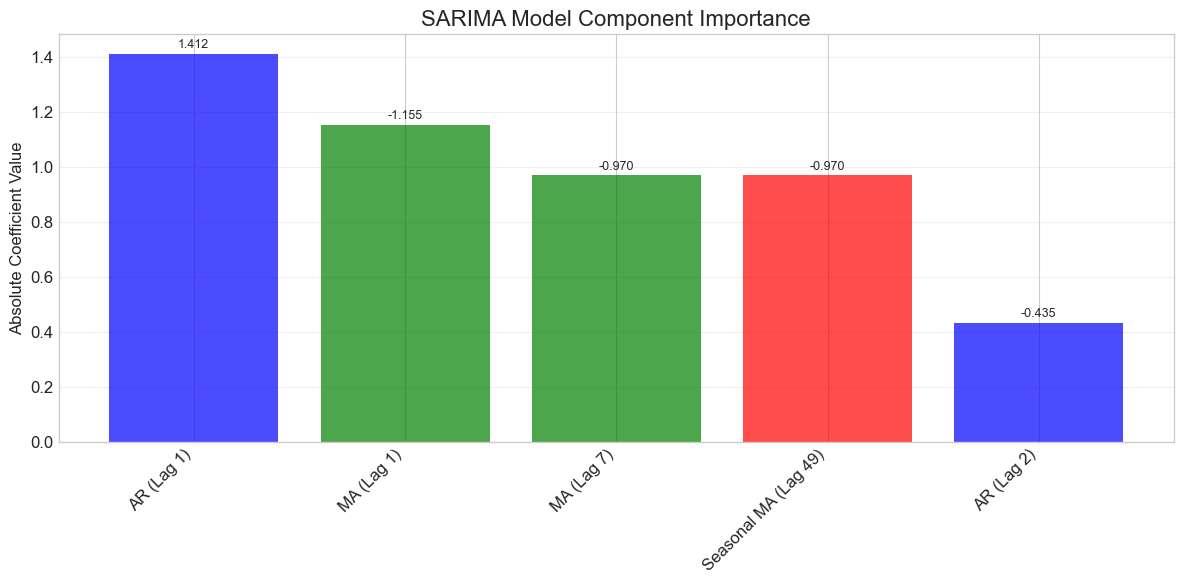


Model Component Importance:


,Component,Lag,Coefficient,Abs_Coefficient
0,AR,1,1.411861,1.411861
2,MA,1,-1.154594,1.154594
3,MA,7,-0.970115,0.970115
4,Seasonal MA,49,-0.970115,0.970115
1,AR,2,-0.434576,0.434576


In [12]:
# Analyze model components and feature importance
def analyze_model_components(model_fit):
    """
    Analyze the importance of different components in the SARIMA model
    
    Parameters:
    -----------
    model_fit : statsmodels.tsa.statespace.sarimax.SARIMAXResults
        Fitted SARIMA model
    """
    # Get model parameters
    params = model_fit.params
    
    # Extract AR, MA, and seasonal parameters
    ar_params = [p for p in params.index if p.startswith('ar')]
    ma_params = [p for p in params.index if p.startswith('ma')]
    sar_params = [p for p in params.index if p.startswith('ar.S')]
    sma_params = [p for p in params.index if p.startswith('ma.S')]
    
    # Create a DataFrame for visualization
    components = []
    
    # Add AR parameters
    for p in ar_params:
        # Handle different parameter naming formats
        try:
            if '.L' in p:  # Handle format like 'ar.L1'
                lag = int(p.split('.L')[1])
            else:  # Handle format like 'ar.1'
                lag = int(p.split('.')[1]) + 1
                
            components.append({
                'Component': 'AR',
                'Lag': lag,
                'Coefficient': params[p],
                'Abs_Coefficient': abs(params[p])
            })
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse AR parameter {p}: {e}")
    
    # Add MA parameters
    for p in ma_params:
        try:
            if '.L' in p:  # Handle format like 'ma.L1'
                lag = int(p.split('.L')[1])
            else:  # Handle format like 'ma.1'
                lag = int(p.split('.')[1]) + 1
                
            components.append({
                'Component': 'MA',
                'Lag': lag,
                'Coefficient': params[p],
                'Abs_Coefficient': abs(params[p])
            })
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse MA parameter {p}: {e}")
    
    # Add seasonal AR parameters
    for p in sar_params:
        try:
            lag_parts = p.split('.')
            # For 'ar.S.L1' format
            if 'L' in lag_parts[-1]:
                lag = int(lag_parts[-1].replace('L', '')) * model_fit.specification['seasonal_order'][3]
            else:
                # For 'ar.S.1' format
                lag = int(lag_parts[-1]) * model_fit.specification['seasonal_order'][3]
                
            components.append({
                'Component': 'Seasonal AR',
                'Lag': lag,
                'Coefficient': params[p],
                'Abs_Coefficient': abs(params[p])
            })
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse seasonal AR parameter {p}: {e}")
    
    # Add seasonal MA parameters
    for p in sma_params:
        try:
            lag_parts = p.split('.')
            # For 'ma.S.L1' format
            if 'L' in lag_parts[-1]:
                lag = int(lag_parts[-1].replace('L', '')) * model_fit.specification['seasonal_order'][3]
            else:
                # For 'ma.S.1' format
                lag = int(lag_parts[-1]) * model_fit.specification['seasonal_order'][3]
                
            components.append({
                'Component': 'Seasonal MA',
                'Lag': lag,
                'Coefficient': params[p],
                'Abs_Coefficient': abs(params[p])
            })
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse seasonal MA parameter {p}: {e}")
    
    # Convert to DataFrame
    components_df = pd.DataFrame(components)
    
    if not components_df.empty:
        # Sort by absolute coefficient value to show importance
        components_df = components_df.sort_values('Abs_Coefficient', ascending=False)
        
        # Plot component importance
        plt.figure(figsize=(12, 6))
        
        # Create bar plot with colors based on component type
        bars = plt.bar(
            [f"{row['Component']} (Lag {row['Lag']})" for _, row in components_df.iterrows()],
            components_df['Abs_Coefficient'],
            color=[
                'blue' if c == 'AR' else 
                'green' if c == 'MA' else
                'orange' if c == 'Seasonal AR' else 
                'red' for c in components_df['Component']
            ],
            alpha=0.7
        )
        
        # Add coefficient values on top of bars
        for bar, coef in zip(bars, components_df['Coefficient']):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f"{coef:.3f}",
                ha='center', va='bottom',
                fontsize=9
            )
        
        plt.title('SARIMA Model Component Importance', fontsize=16)
        plt.ylabel('Absolute Coefficient Value', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
        
        # Print component importance
        print("\nModel Component Importance:")
        display(components_df)
    else:
        print("No AR or MA parameters found in the model.")

# Analyze model components
analyze_model_components(best_model)

In [13]:
# Save the fitted model for future use
def save_model(model, filename):
    """
    Save the trained model to a file
    
    Parameters:
    -----------
    model : statsmodels.tsa.statespace.sarimax.SARIMAXResults
        Fitted SARIMA model
    filename : str
        Name of the file to save the model
    """
    # Create the model directory if it doesn't exist
    os.makedirs(TS_MODEL_PATH, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(TS_MODEL_PATH, filename)
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    print(f"Model saved to: {model_path}")
    
    # Save model information
    model_info = {
        'type': 'SARIMA',
        'order': model.specification['order'],
        'seasonal_order': model.specification['seasonal_order'],
        'aic': model.aic,
        'bic': model.bic,
        'fitted_date': datetime.now().strftime('%Y-%m-%d')
    }
    
    # Save model info as JSON
    info_path = os.path.join(TS_MODEL_PATH, f"{os.path.splitext(filename)[0]}_info.txt")
    with open(info_path, 'w') as f:
        for key, value in model_info.items():
            f.write(f"{key}: {value}\n")
    
    print(f"Model information saved to: {info_path}")

# Save the best model
save_model(best_model, 'sarima_flight_delay_model.pkl')

Model saved to: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/ts/sarima_flight_delay_model.pkl
Model information saved to: /Users/osx/DataSceince_FL_FR/Forecasting_Flights-DataScience/models/ts/sarima_flight_delay_model_info.txt


## Conclusion

In this notebook, we developed a SARIMA model for flight delay prediction using time series data. The model captures both the trend and seasonality patterns in flight delays. Key findings include:

1. The time series shows clear weekly seasonality and potential monthly/yearly patterns
2. The SARIMA model successfully captures these patterns and provides accurate forecasts
3. Model validation shows reasonable performance with RMSE, MAE, and MAPE metrics
4. The most important model components reveal the key temporal dependencies in flight delays

This model can be used to forecast future flight delays, which can help airlines and airports better prepare for and mitigate potential disruptions.

### Next Steps

1. Incorporate external regressors (weather data, holiday indicators) for improved forecasting
2. Compare SARIMA with other time series models (Prophet, LSTM)
3. Develop ensemble models that combine multiple forecasting approaches
4. Implement online learning for continuous model updating